In [30]:
import numpy as np
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt

In [31]:
#Data

with open('./Data/p4.csv', 'r') as f:
    results = []
    next(f)
    for line in f:
        words = line.split(',')
        for i in range(len(words)):
            words[i] = float(words[i])
        results.append(words)

In [32]:
Data = np.array(results)
y = Data[:, 0].astype(int)
X = np.delete(Data, 0, axis = 1)

In [33]:
print(X.shape)
print(y.shape)

(60000, 784)
(60000,)


## *K Means Clusturing*

In [34]:
def distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

In [35]:
class KMeans:
    def __init__(self, K=5, max_iters=100):
        self.K = K
        self.max_iters = max_iters

        # list of sample indices for each cluster
        self.clusters = [[] for _ in range(self.K)]
        # the centers (mean feature vector) for each cluster
        self.centroids = []

    def _closest_centroid(self, sample, centroids):
        # distance of the current sample to each centroid
        distances = [distance(sample, point) for point in centroids]
        closest_index = np.argmin(distances)
        return closest_index

    def _create_clusters(self, centroids):
        # Assign the samples to the closest centroids to create clusters
        clusters = [[] for _ in range(self.K)]
        for idx, sample in enumerate(self.X):
            centroid_idx = self._closest_centroid(sample, centroids)
            clusters[centroid_idx].append(idx)
        return clusters

    def _get_centroids(self, clusters):
        # assign mean value of clusters to centroids
        centroids = np.zeros((self.K, self.n_features))
        for cluster_idx, cluster in enumerate(clusters):
            cluster_mean = np.mean(self.X[cluster], axis=0)
            centroids[cluster_idx] = cluster_mean
        return centroids

    def _get_cluster_labels(self, clusters):
        # each sample will get the label of the cluster it was assigned to
        labels = np.empty(self.n_samples)

        for cluster_idx, cluster in enumerate(clusters):
            for sample_index in cluster:
                labels[sample_index] = cluster_idx
        return labels

    def _is_converged(self, centroids_old, centroids):
        # distances between each old and new centroids, fol all centroids
        distances = [
            distance(centroids_old[i], centroids[i]) for i in range(self.K)
        ]
        return sum(distances) == 0


    def predict(self, X):
        self.X = X
        self.n_samples, self.n_features = X.shape

        # initialize
        random_sample_idxs = np.random.choice(self.n_samples, self.K, replace=False)
        self.centroids = [self.X[idx] for idx in random_sample_idxs]

        # Optimize clusters
        for _ in range(self.max_iters):
            # Assign samples to closest centroids (create clusters)
            self.clusters = self._create_clusters(self.centroids)

            # Calculate new centroids from the clusters
            centroids_old = self.centroids
            self.centroids = self._get_centroids(self.clusters)
            
            # check if clusters have changed
            if self._is_converged(centroids_old, self.centroids):
                break
        
        # Classify samples as the index of their clusters
        return self._get_cluster_labels(self.clusters), self.centroids

In [36]:
def mutual_information(labels_true, labels_pred):
    # Compute the contingency table
    contingency = np.zeros((len(np.unique(labels_true)), len(np.unique(labels_pred))))
    for i, j in zip(labels_true, labels_pred):
        contingency[i.astype(int), j.astype(int)] += 1

    # Compute the marginal sums over rows and columns
    sum_rows = np.sum(contingency, axis=1)
    sum_cols = np.sum(contingency, axis=0)

    # Compute the total number of samples
    N = np.sum(sum_rows)

    # Compute the entropy of the true labels and predicted labels
    H_true = -np.sum((sum_rows / N) * np.log2(sum_rows / N))
    H_pred = -np.sum((sum_cols / N) * np.log2(sum_cols / N))

    # Compute the mutual information
    mi = 0.0
    for i in range(contingency.shape[0]):
        for j in range(contingency.shape[1]):
            if contingency[i, j] > 0:
                mi += (contingency[i, j] / N) * np.log2((contingency[i, j] * N) / (sum_rows[i] * sum_cols[j]))

    return mi, H_true, H_pred

In [37]:
def normalized_mutual_information(labels_true, labels_pred):
    # Compute the mutual information, entropy of true labels, and entropy of predicted labels
    mi, H_true, H_pred = mutual_information(labels_true, labels_pred)

    # Compute the normalized mutual information
    nmi = (2.0 * mi) / (H_true + H_pred)

    return nmi

In [40]:
nmi = []
for i in range(1,16):
    model = KMeans(i ,max_iters = 50)
    pred,_ = model.predict(X)
    x = normalized_mutual_information(y,pred)
    print(x)
    nmi.append(x)

0.0
0.1839756665463972
0.42475277783727416
0.4744034736728208
0.549842573757406
0.5979937945145509
0.608564124493453
0.6762360085348628
0.6200991175403265
0.6963068806399693
0.7043699228877075
0.707446148935485
0.7105719637089181
0.7091004431530186
0.7131391015750868


In [41]:
print('Normalized Mutual Information for 1 - 15\n', nmi)

Normalized Mutual Information for 1 - 15
 [0.0, 0.1839756665463972, 0.42475277783727416, 0.4744034736728208, 0.549842573757406, 0.5979937945145509, 0.608564124493453, 0.6762360085348628, 0.6200991175403265, 0.6963068806399693, 0.7043699228877075, 0.707446148935485, 0.7105719637089181, 0.7091004431530186, 0.7131391015750868]


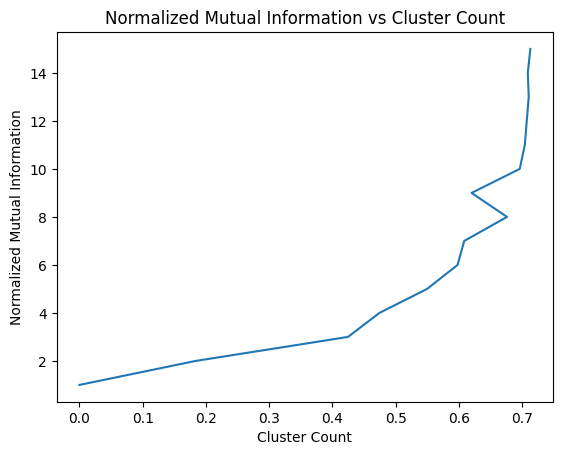

In [43]:
# Create the plot
clusters = list(range(1, 16))
plt.plot(nmi, clusters)
plt.title('Normalized Mutual Information vs Cluster Count')
plt.xlabel('Cluster Count')
plt.ylabel('Normalized Mutual Information')
plt.show()

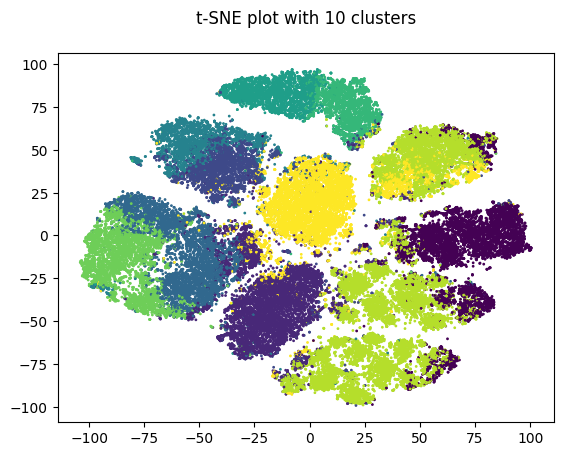

In [44]:
model = KMeans(10)
labels, centroids = model.predict(X)
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=labels , s=1)
plt.title("t-SNE plot with {} clusters\n".format(10))
plt.show()

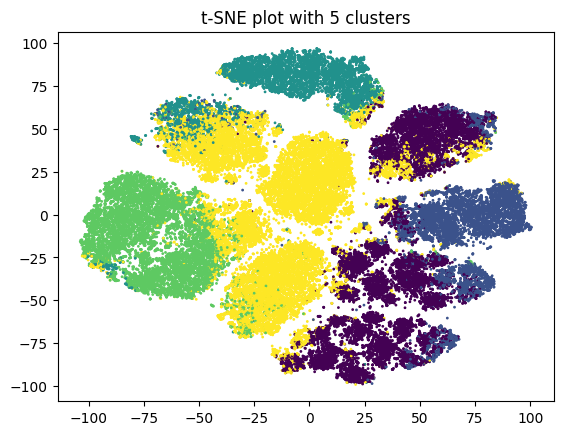

In [45]:
model = KMeans(5)
labels, centroids = model.predict(X)
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=labels , s=1)
plt.title("t-SNE plot with {} clusters".format(5))
plt.show()

## *Gaussian Mixture Model*

In [46]:
class Gaussian_Mixture_Model:
    
    def __init__(self,mixtures):
        self.mixtures = mixtures
        self.feature_dimension = None
        self.means = None
        #self.cov = None
        self.alpha = np.ones(self.mixtures)/self.mixtures

    def __Initialize_parameters(self):
        self.means = []
        self.cov = []
        for j in range(self.mixtures):
            self.means.append(np.random.random_sample((self.feature_dimension)))
            #self.cov.append(np.eye(self.feature_dimension)))

    def __gaussian(self,x,mean):   
        z = x - mean
        return np.exp(-0.5*z@z.T)
     
    def __update_mean(self,data,gamma,n_j):
        N = data.shape[0]
        sum = 0
        for i in range(N):
            sum += gamma[i]*data[i]
        return sum/n_j
    
    
    def __EM_update(self,data,epochs):
        num_data_points = data.shape[0]
        gamma = []
        for i in range(self.mixtures):
            temp = np.zeros(num_data_points)
            gamma.append(temp)
        
        for i in range(epochs):
            for k in range(num_data_points):
                temp2 = np.zeros(self.mixtures)
                for l in range(self.mixtures):
                    gauss = self.__gaussian(data[k],self.means[l])                  
                    temp2[l] = gauss
                temp2  = temp2*self.alpha
                for l in range(self.mixtures):
                    gamma[l][k] = temp2[l]/np.sum(temp2)
            
            for j in range(self.mixtures):                
                n_j = np.sum(gamma[j])
                self.means[j] = self.__update_mean(data,gamma[j],n_j)
                self.alpha[j] = n_j/num_data_points
    
    def predict(self,X,epochs):
        self.feature_dimension = X.shape[1]
        self.__Initialize_parameters()
        self.__EM_update(X,epochs)
        probs = np.zeros((X.shape[0], self.mixtures))
        for i in range(X.shape[0]):
            for j in range(self.mixtures):
                probs[i, j] = self.alpha[j] *self.__gaussian(X[i],self.means[j])

        # Predict the cluster assignments
        return np.argmax(probs, axis=1)

In [47]:
# MinMax Normalizing
X = X / 255

In [50]:
nmi = []
for i in range(1,16):
    model = Gaussian_Mixture_Model(i)
    pred = model.predict(X, 15)
    x = normalized_mutual_information(y,pred)
    print(x)
    nmi.append(x)

0.0
0.1767799478854697
0.3474381983269997
0.43044391051429715
0.4685383912760663
0.585469060361345
0.580925325751928
0.6094932331249232
0.6340995641126872
0.690591420258008
0.6635213623062568
0.6870042835708734
0.6202676858657806
0.6839458272251777
0.6172846067569624


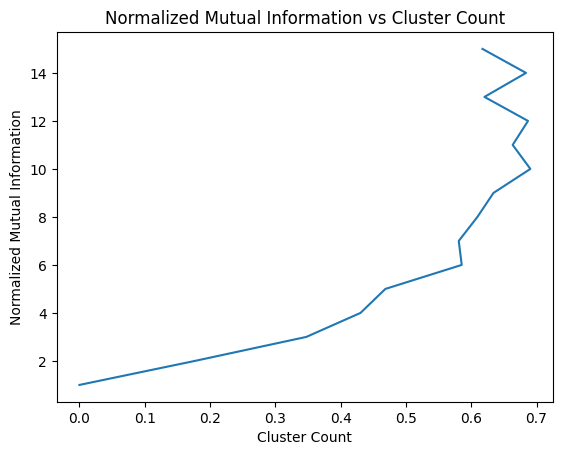

In [51]:
# Create the plot
clusters = list(range(1, 16))
plt.plot(nmi, clusters)
plt.title('Normalized Mutual Information vs Cluster Count')
plt.xlabel('Cluster Count')
plt.ylabel('Normalized Mutual Information')
plt.show()

GMM with 10 mixtures

Normalized Mutual Information = 0.6795771852531548 



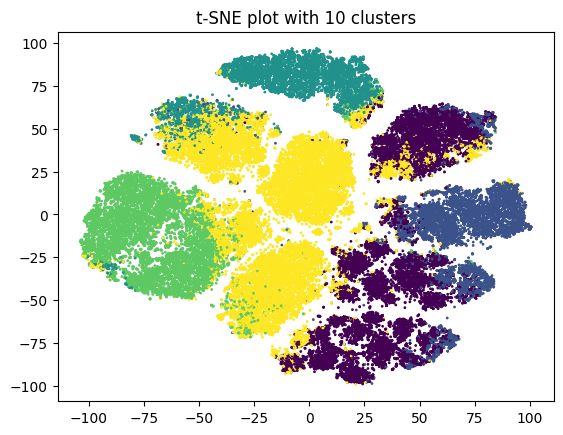

In [48]:
gmm = Gaussian_Mixture_Model(10)
pred = gmm.predict(X, 15)
print('GMM with 10 mixtures\n')
print('Normalized Mutual Information =', normalized_mutual_information(y,pred), '\n')
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=labels , s=1)
plt.title("t-SNE plot with {} clusters".format(10))
plt.show()

GMM with 5 mixtures

Normalized Mutual Information = 0.46721033287223107 



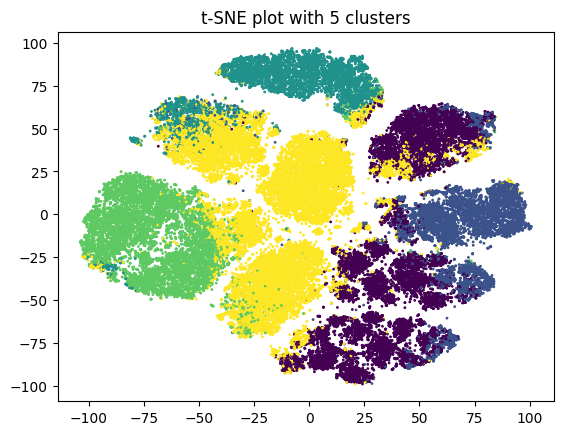

In [49]:
gmm = Gaussian_Mixture_Model(5)
pred = gmm.predict(X, 10)
print('GMM with 5 mixtures\n')
print('Normalized Mutual Information =', normalized_mutual_information(y,pred), '\n')
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=labels , s=1)
plt.title("t-SNE plot with {} clusters".format(5))
plt.show()